### Let's actually apply Top-K and compare Perplexity

In [1]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Block
from torch import nn
from typing import Optional, Tuple, Union
import torch
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer, GPT2LMHeadModel
from matplotlib import pyplot as plt
from utils.datasets import get_top_n_tiny_shakespeare

class TopKGPT2Block(GPT2Block):
    def __init__(self, config, layer_idx=None):
        super().__init__(config, layer_idx=None)
        self.intermediate_outputs = {}
        
    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        def fine_grained_prune(tensor: torch.Tensor, sparsity : float=0.5) -> torch.Tensor:
            # From efficient GPU HW3
            """
            magnitude-based pruning for single tensor
            :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
            :param sparsity: float, pruning sparsity
                sparsity = #zeros / #elements = 1 - #nonzeros / #elements
            :return:
                torch.(cuda.)Tensor, mask for zeros
            """
            sparsity = min(max(0.0, sparsity), 1.0)
            if sparsity == 1.0:
                tensor.zero_()
                return torch.zeros_like(tensor)
            elif sparsity == 0.0:
                return torch.ones_like(tensor)

            num_elements = tensor.numel()

            ##################### YOUR CODE STARTS HERE #####################
            # Step 1: calculate the #zeros (please use round())
            num_zeros = round(sparsity * num_elements)
            # Step 2: calculate the importance of weight
            importance = tensor.abs()
            # Step 3: calculate the pruning threshold

            # print("importance.shape: ", importance.shape)
            # print("num_zeros: ", num_zeros)

            threshold, index = torch.kthvalue(importance.flatten(), num_zeros)  # Used ChatGPT here to flatten (fix RuntimeError)
            # print("threshold: ", threshold)
            # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
            # print(importance < threshold)
            mask = importance > threshold
            # mask = torch.zeros_like(importance, dtype=torch.bool)  # Used ChatGPT here, didn't work - incorrect logic!
            ##################### YOUR CODE ENDS HERE #######################

            # Step 5: apply mask to prune the tensor
            tensor.mul_(mask)

            return mask
        # Dictionary to store all intermediate outputs
        residual = hidden_states  # Identical debug to GPT2Block so far

        self.intermediate_outputs['initial_residual'] = residual.detach().clone()
        self.intermediate_outputs['initial_hidden_states'] = hidden_states.detach().clone()

        hidden_states = self.ln_1(hidden_states) # Also identical

        fine_grained_prune(residual)
        # Apply Fine-grained pruning to hidden_states
        fine_grained_prune(hidden_states)  # In-place
    
        # Store initial hidden states
        self.intermediate_outputs['post_ln1_residual'] = residual.detach().clone()
        self.intermediate_outputs['post_ln1_hidden_states'] = hidden_states.detach().clone()

        
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]  # Why is attn_output and outputs different? What do they mean?

        self.intermediate_outputs['attn_projection_output'] = attn_output.detach().clone()
        # residual connection
        hidden_states = attn_output + residual
        # Top-Kify
        fine_grained_prune(hidden_states)
        self.intermediate_outputs['post_attn_residual_hidden_states'] = hidden_states.detach().clone()

        # Where is * W0? Is it inside self.attn?

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        self.intermediate_outputs['post_cross_attn_residual'] = residual.detach().clone()
        self.intermediate_outputs['post_cross_attn_hidden_states'] = hidden_states.detach().clone()

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)

        fine_grained_prune(hidden_states)

        self.intermediate_outputs['post_ln2_residual'] = residual.detach().clone()
        self.intermediate_outputs['post_ln2_hidden_states'] = hidden_states.detach().clone()

        feed_forward_hidden_states = self.mlp(hidden_states)
        self.intermediate_outputs['post_feed_fwd_hidden_states'] = hidden_states.detach().clone()
        # residual connection
        hidden_states = residual + feed_forward_hidden_states
        
        fine_grained_prune(hidden_states)
        self.intermediate_outputs['post_feed_fwd_residual_hidden_states'] = hidden_states.detach().clone()

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)


class TopKGPT2Model(GPT2Model):
    def __init__(self, config):
        super().__init__(config)

        self.embed_dim = config.hidden_size

        self.wte = nn.Embedding(config.vocab_size, self.embed_dim)
        self.wpe = nn.Embedding(config.max_position_embeddings, self.embed_dim)

        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([TopKGPT2Block(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.ln_f = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_epsilon)

        # Model parallel
        self.model_parallel = False
        self.device_map = None
        self.gradient_checkpointing = False
        self._attn_implementation = config._attn_implementation

        # Initialize weights and apply final processing
        self.post_init()
        self.all_intermediate_outputs = []

In [2]:
config = GPT2Config()
topk_model = TopKGPT2Model(config).eval()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

topk_model_with_gpt2_head = GPT2LMHeadModel(config)

topk_model_with_gpt2_head.transformer = topk_model

topk_model_with_gpt2_head = topk_model_with_gpt2_head.eval()

In [3]:
from utils.datasets import get_top_n_tiny_shakespeare

top_n_tiny_shakespeare = get_top_n_tiny_shakespeare(n=1)

In [4]:
input_ids = tokenizer(top_n_tiny_shakespeare[0]['Text'], return_tensors="pt")['input_ids']

out = topk_model(input_ids)

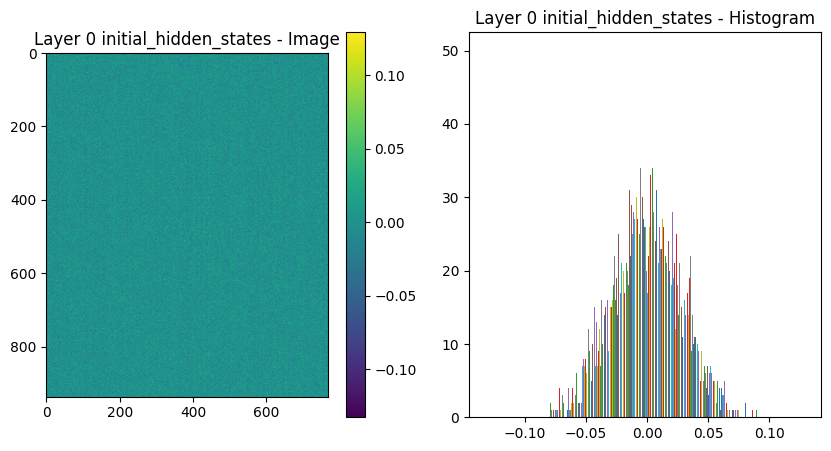

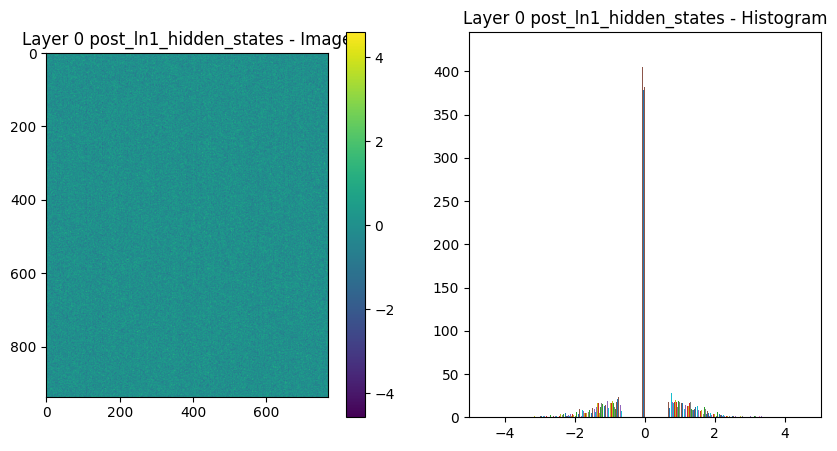

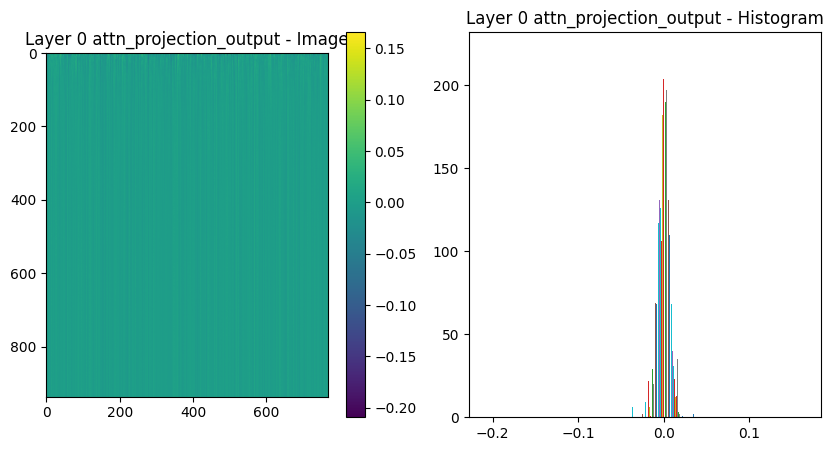

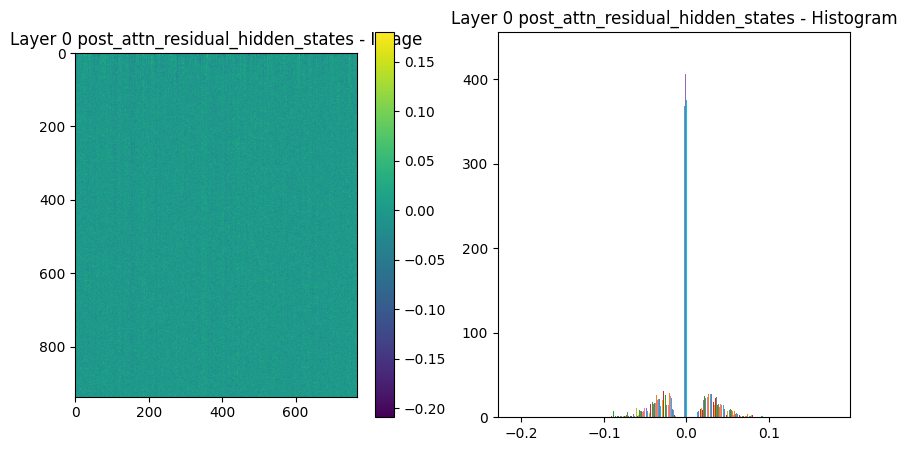

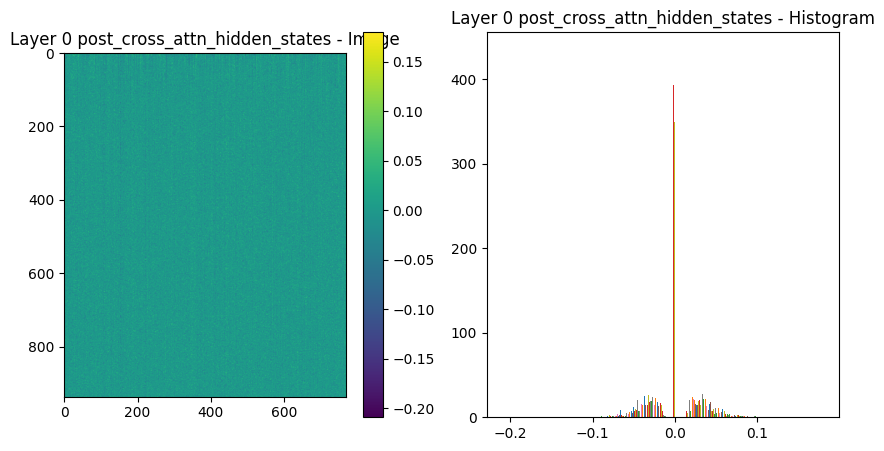

In [5]:
from utils.model import plot_intermediate_model_outputs

plot_intermediate_model_outputs(topk_model)